# Fake News Detection - Mini Project

## Data Source

The data used in this notebook is extracted from the "Fake News" Kaggle competition (https://www.kaggle.com/competitions/fake-news/code?competitionId=8317&sortBy=voteCount&excludeNonAccessedDatasources=true)

#### Imports

In [5]:
# Dataframes and arrays
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
from sklearn.feature_extraction.text import CountVectorizer

# NLP and Models
from transformers import BertTokenizer
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch import nn
from transformers import BertModel, BertConfig
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split

# Misc
import os
import warnings
warnings.filterwarnings('ignore')
from utils import count_occurance, remove_web_addresses, remove_special_chrs

#### Variables

In [209]:
SEED = 42
batch_size = 32

np.random.seed(SEED)

#### Data split

The Kaggle competiton data provides only the train set with the ground truth labels, along with the test set and no labels. To test our model, we will partition the train set into 80% for training and the remaining 20% for testing purposes.

In [166]:
# If train-test split exists, use it.
if os.path.exists('./data/X_train.csv') & os.path.exists('./data/y_train.csv') & os.path.exists('./data/X_test.csv') & os.path.exists('./data/y_test.csv'):
    X_train = pd.read_csv('./data/X_train.csv')
    y_train = pd.read_csv('./data/y_train.csv')

    X_test = pd.read_csv('./data/X_test.csv')
    y_test = pd.read_csv('./data/y_test.csv')

# Else, read raw data and make splits
else:
    try:
        raw = pd.read_csv("data/kaggle/train.csv", encoding="utf-8")
        raw.drop("id", axis=1, inplace=True)
        X, y = raw.iloc[:,:-1], raw.iloc[:,-1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
        X_train.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        y_train.reset_index(drop=True, inplace=True)
        y_test.reset_index(drop=True, inplace=True)
        y_train = pd.DataFrame(y_train, columns="label")
        y_test = pd.DataFrame(y_test, columns="label")

    except:
        raise FileNotFoundError("Couldn't find dataset.")

## EDA

Shapes

In [167]:
print("Training data shape: ", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape:  (16640, 3)
Test data shape: (4160, 3)


Inspect the data structure

In [168]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16640 entries, 0 to 16639
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   16182 non-null  object
 1   author  15066 non-null  object
 2   text    16610 non-null  object
dtypes: object(3)
memory usage: 390.1+ KB


It appears there are some null values in 'title', 'author' and 'text'. We will remove all rows with null 'text', since this is our main predictor.

In [169]:
X_train.dropna(subset="text", inplace=True)
y_train = y_train.loc[X_train.index]
print(X_train.shape, y_train.shape)

(16610, 3) (16610, 1)


Inspect the first rows of training data

In [170]:
X_train.head()

,title,author,text
0,"Raccoons in Central Park Draw Crowds, and Warn...",Sarah Maslin Nir,"Like a little crew of bandits, the first few..."
1,Bolton on Susan Rice Scandal: Obama Needs to B...,John Hayward,"On Thursday’s Breitbart News Daily, SiriusXM h..."
2,IF HILLARY CLINTON IS CHARGED WITH OBSTRUCTION...,Iron Sheik,Home › POLITICS › IF HILLARY CLINTON IS CHARGE...
3,New York Times’s Moscow Bureau Was Targeted by...,Nicole Perlroth and David E. Sanger,The New York Times’s Moscow bureau was the tar...
4,Gays Against Sharia March Branded ’Islamophobi...,Donna Rachel Edmunds,An event organised by Gays Against Sharia to m...


### Analyzing Titles

In [171]:
X_train['title'].value_counts()

What to Cook This Week - The New York Times                                                                                  4
Las imágenes libres de derechos más destacadas de la semana                                                                  4
Will Barack Obama Delay Or Suspend The Election If Hillary Is Forced Out By The New FBI Email Investigation?                 4
The Fix Is In: NBC Affiliate Accidentally Posts Election Results A Week Early: Hillary Wins Presidency 42% to Trump’s 40%    4
The Dark Agenda Behind Globalism And Open Borders                                                                            4
                                                                                                                            ..
ABC10 Photographer Attacked With Hot Coffee Outside MILO UC Davis Event - Breitbart                                          1
Life at migrant centers in Germany: RT talks to volunteers, refugees about their hopes & fears                 

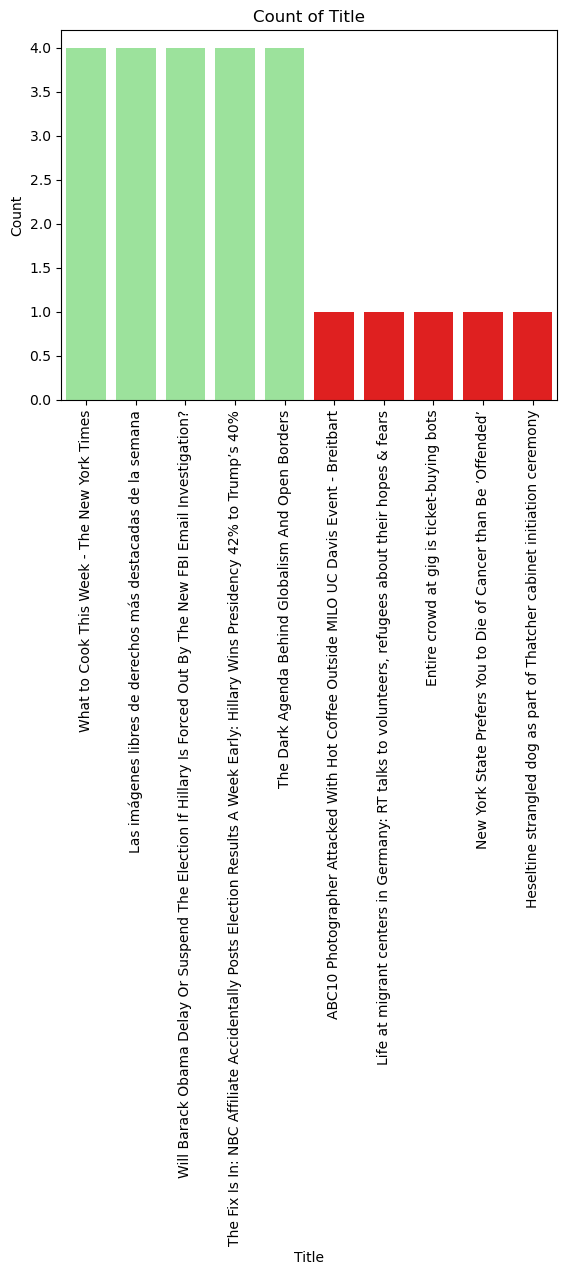

In [172]:
count_occurance(df=X_train, column='title')


The **"title"** column is a string type with 458 null entries. Analysis shows a generally balanced title frequency, something expected for this dataset; although a few titles, like **"Will Barack Obama Delay Or Suspend The Election If Hillary Is Forced Out By The New FBI Email Investigation?",** appear more than one time, suggesting either duplicates or reposts.

### Analyzing Authors

In [173]:
X_train['author'].value_counts()

Pam Key                             193
admin                               161
Jerome Hudson                       130
John Hayward                        116
Charlie Spiering                    115
                                   ... 
Robert Lipsyte                        1
Ellen Barry and Nida Najar            1
James Risen and Sheri Fink            1
Peter Koenig                          1
Norimitsu Onishi and Sewell Chan      1
Name: author, Length: 3660, dtype: int64

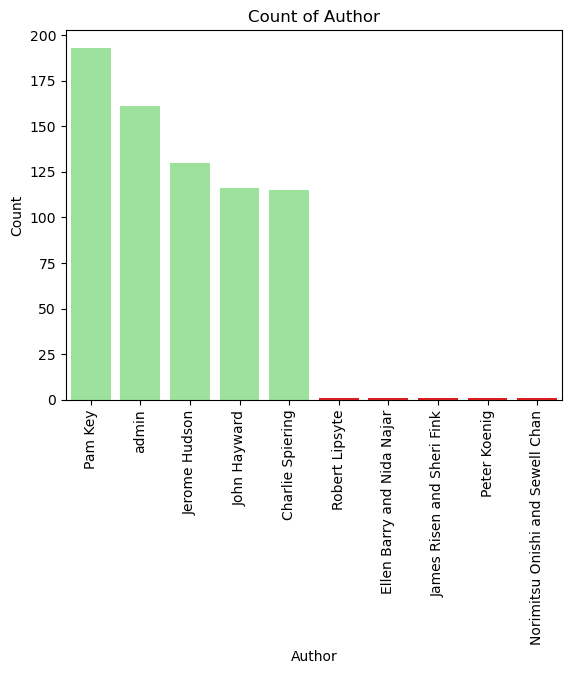

In [174]:
count_occurance(X_train, "author")

The **"author"** column is a string type with 1574 null entries. Our analysis highlights a significant imbalance in **"author"** frequency within our training set. **"Pam Key"** is notably prevalent, appearing 193 times, suggesting over-representation. Conversely, **"Peter Koenig"** and several others are mentioned only once, indicating under-representation. This disparity hints some authors are more profilerant news spreaders. We will now inspect if these authors correlate with either trustworthy or fake news.

### Authors' trustworthiness

To analyse the authors' trustworthiness, we will look at those authors with more than 50 news, and analyse the ratio of trustworthy vs Fake news.

In [175]:
truth_by_author = pd.concat([X_train, y_train], axis=1)[["author", "label"]].groupby(["author"]).agg(N=("label", "count"), truthful=("label", lambda x: (x==1).sum()), fake=("label", lambda x: (x==0).sum()), Truth=("label", "mean"))
truth_by_author[truth_by_author.N > 50].sort_values("Truth", ascending=False)

,N,truthful,fake,Truth
author,,,,
Henry Wolff,55,55,0,1.000000
Eddy Lavine,62,62,0,1.000000
noreply@blogger.com (Alexander Light),65,65,0,1.000000
admin,161,161,0,1.000000
The European Union Times,58,58,0,1.000000
The Doc,58,58,0,1.000000
Starkman,59,59,0,1.000000
Pakalert,68,68,0,1.000000
Kaitlyn Stegall,53,53,0,1.000000


Surprisingly, the results show an extremely polarized picture: when looking at proliferant news spreaders (>50 news), we can see a clean cut between extremely trustworthy authors and fake news spreaders. This gives us an important insight into the task. Adding "author" as a contextual information could serve as a direct proxy for the classification. This, on the other hand, could have unexpected results. We could be directly banning author's regardless of their shift in publications.

### Vocabulary Analysis

In [177]:
vectorizer = CountVectorizer(stop_words='english', max_features=None)
X = vectorizer.fit_transform(X_train['text'])

# finding the most common words
words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
top_words = words.sum().sort_values(ascending=False)
top_words.head(20)

said          63836
mr            52455
trump         44998
people        29088
new           23958
clinton       22532
like          21205
president     20218
just          17702
time          16961
state         16197
years         14315
states        13836
government    13303
american      12736
world         12642
year          12278
news          12195
hillary       11929
obama         11875
dtype: int64

Our vocabulary analysis reveals that terms associated with politics are most frequent in our dataset, confirming that fake news have often a political goal. Key words such as **"trump," "clinton," "president," "government," "obama," and "state"** dominate the content, highlighting a strong political focus in the news.
An interesting question is: Are some of these tokens more frequently associated with a specific label?

### Label - Token association

In [179]:
truth = vectorizer.fit_transform(X_train[y_train.label == 0]['text'])
truth_words = pd.DataFrame(truth.toarray(), columns=vectorizer.get_feature_names_out())
truth_words = truth_words.sum().sort_values(ascending=False).reset_index()
truth_words.rename(columns={"index": "token", 0: "Truth"}, inplace=True)


fake = vectorizer.fit_transform(X_train[y_train.label == 1]['text'])
fake_words = pd.DataFrame(fake.toarray(), columns=vectorizer.get_feature_names_out())
fake_words = fake_words.sum().sort_values(ascending=False).reset_index()
fake_words.rename(columns={"index": "token", 0: "Fake"}, inplace=True)

token_trust = truth_words.merge(fake_words, on="token", how="outer")
token_trust["n"] = token_trust.Truth + token_trust.Fake
token_trust["Fake %"] = token_trust.Fake / token_trust.n

Let's see the most frequent terms and their "Fake rate"

In [180]:
token_trust.sort_values("n", ascending=False).head(20)

,token,Truth,Fake,n,Fake %
0,said,54284.0,9552.0,63836.0,0.149633
1,mr,51103.0,1352.0,52455.0,0.025774
2,trump,28828.0,16170.0,44998.0,0.359349
3,people,15836.0,13252.0,29088.0,0.455583
4,new,15621.0,8337.0,23958.0,0.347984
19,clinton,6700.0,15832.0,22532.0,0.702645
6,like,12782.0,8423.0,21205.0,0.397218
5,president,13453.0,6765.0,20218.0,0.334603
9,just,9174.0,8528.0,17702.0,0.481753
8,time,9452.0,7509.0,16961.0,0.442722


Which terms are most associated with fake reviews?

In [181]:
token_trust.sort_values("Fake %", ascending=False).head(20)

,token,Truth,Fake,n,Fake %
45404,на,3.0,1279.0,1282.0,0.997660
79362,oligarchy,1.0,258.0,259.0,0.996139
58093,und,2.0,490.0,492.0,0.995935
85970,más,1.0,232.0,233.0,0.995708
70059,ist,1.0,208.0,209.0,0.995215
61538,ufo,1.0,198.0,199.0,0.994975
63491,widget,1.0,191.0,192.0,0.994792
84354,mails,1.0,189.0,190.0,0.994737
77790,ein,1.0,183.0,184.0,0.994565
65556,th,1.0,182.0,183.0,0.994536


Interestingly, some of the tokens most associated to fake news, are foreign language tokens, with some russian (на, есть), german (und, ist, ein, ich) and spanish (más, una, su) standing out.

 ### Distribution of Labels

In [182]:
y_train['label'].value_counts()

1    8355
0    8255
Name: label, dtype: int64

- Label 1 = Fake News (8385 news labeled as FAKE news)

- Label 0 = Real News (8255 news labeled as REAL news)

We can see an almost an equal amount of labeled true and fake news.

## Data Preparation: Preprocessing

### Replacing tokens

We will replace all web addresses by a simple tag, to regularize the number of tokens

In [183]:
X_train["text"] = X_train["text"].apply(remove_web_addresses)
X_train["text"] = X_train["text"].apply(remove_special_chrs)
X_test.fillna("", inplace=True)
X_test["text"] = X_test["text"].apply(remove_web_addresses)
X_test["text"] = X_test["text"].apply(remove_special_chrs)

### Tokenization

We use the bert tokenizer, and build a encoder function to parse the data for the BERT model.

In [184]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def encode_data(data):

    input_ids = []
    attention_masks = []
    
    for text in data["text"]:
        encoded_dict = tokenizer.encode_plus(
                            text,                     
                            add_special_tokens = True,
                            truncation = "longest_first", # only sequences that are truncated are the ones that really need it due to their excessive length
                            max_length = 74,         
                            pad_to_max_length = True,
                            return_attention_mask = True,  
                            return_tensors = 'pt',
                    )
        
        # add the encoded sentence to the list
        input_ids.append(encoded_dict['input_ids'])
        
        # add the attention mask
        attention_masks.append(encoded_dict['attention_mask'])

    # convert the lists into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

## Transformer Model: BERT

We build a binary classifier on top of a pre-trained BERT transformer.

In [185]:
def build_model():
    # configuring the BERT model for binary classification.
    config = BertConfig.from_pretrained(
        "bert-base-uncased",
        num_labels=1,  # indicates that we are doing binary classification
        output_attentions=False,  # specifies if the model returns attentions weights.
        output_hidden_states=False,  # specifies if the model returns all hidden-states.
    )
    
    # loading the pre-trained BERT model 
    bert_layer = BertModel.from_pretrained("bert-base-uncased", config=config)

    class BertForBinaryClassification(nn.Module):
        def __init__(self):
            super().__init__()
            self.bert = bert_layer  # the BERT model layer
            self.dropout = nn.Dropout(0.1)  # dropout layer to prevent overfitting
            self.classifier = nn.Linear(config.hidden_size, 1)  # a linear layer for classification

        def forward(self, input_ids, attention_mask=None):
            outputs = self.bert(input_ids, attention_mask=attention_mask)
            pooled_output = outputs[1]  # the pooled_output is the representation of the [CLS] token
            drop_output = self.dropout(pooled_output)  # applying dropout to the [CLS] token representation
            logits = self.classifier(drop_output)  # pass through the classifier to get the prediction logits
            probabilities = torch.sigmoid(logits)
            predicted_class = (probabilities > 0.5).int()
            # return logits
            return {'label': predicted_class, 'prob_fake_news': probabilities, 'prob_real_news': 1 - probabilities}

    return BertForBinaryClassification()


def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            output = model(b_input_ids, attention_mask=b_input_mask)
            logits = output['label']
            predictions = torch.round(torch.sigmoid(logits))
            all_predictions.extend(predictions)
            all_labels.extend(b_labels)
    
    all_predictions = torch.stack(all_predictions).detach().numpy()
    all_labels = torch.stack(all_labels).detach().numpy()
    
    return all_labels, all_predictions

Use our build model function.

In [186]:
model = build_model()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training the model

NOTE: The model has been trained on ITU's HPC for a total of approximately 30 hs. We load the trained model for efficiency.

In [6]:
if os.path.exists("./models/best_model.bin"):
    print("The model already exists.")

    train_model = False

    try: 
        state_dict = torch.load('./models/best_model.bin')
        model.load_state_dict(state_dict)
    except:
        try:
            # remove unexpected keys
            state_dict.pop('bert.embeddings.position_ids', None)
        except:
            print("Couldn't load the model. Training again.")
            train_model = True

if train_model:
    # Prepare the data
    train_input_ids, train_attention_masks = encode_data(X_train)
    test_input_ids, test_attention_maks = encode_data(X_test)

    # reseting the indices of the DataFrame
    X_train.reset_index(drop=True, inplace=True)

    # converting labels into tensors
    labels = torch.tensor(y_train['label'])

    #train and validation sets split
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_input_ids, labels, random_state=SEED, test_size=0.2)
    train_masks, validation_masks, _, _ = train_test_split(train_attention_masks, labels, random_state=SEED, test_size=0.2)

    # dataLoader for training and validation sets
    train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
    validation_dataset = TensorDataset(validation_inputs, validation_masks, validation_labels)

    train_dataloader = DataLoader(
        train_dataset,
        sampler=RandomSampler(train_dataset),
        batch_size=batch_size
    )

    validation_dataloader = DataLoader(
        validation_dataset,
        sampler=SequentialSampler(validation_dataset),
        batch_size=batch_size
    )

    # initialize the optimizer
    optimizer = optim.Adam(model.parameters(), lr=2e-5)

    # since this is a binary classification problem, we use BCEWithLogitsLoss
    loss_fn = nn.BCEWithLogitsLoss()

    # number of epochs to train
    num_epochs = 5  # we can always change this and play around
    best_val_loss = float('inf')

    # training loop

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for batch in train_dataloader:
            b_input_ids, b_input_mask, b_labels = batch

            # clear previous gradients
            model.zero_grad()

            # perform a forward pass, the forward method will return the logits
            logits = model(b_input_ids, attention_mask=b_input_mask)

            # compute loss and perform a backward pass
            loss = loss_fn(logits.view(-1), b_labels.float())  # we can adjust the shape of logits and labels if necessary
            loss.backward()
            total_train_loss += loss.item()

            # update parameters
            optimizer.step()

        # print training loss after each epoch
        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.3f}')

        # validation phase
        
        model.eval() # evaluation mode
        total_val_loss = 0
        
        with torch.no_grad():  # deactivating autograd for evaluation
            for batch in validation_dataloader:
                b_input_ids, b_input_mask, b_labels = batch
                logits = model(b_input_ids, attention_mask=b_input_mask)
                loss = loss_fn(logits.view(-1), b_labels.float())  # computing validation loss
                total_val_loss += loss.item()

        # calculating average validation loss
        avg_val_loss = total_val_loss / len(validation_dataloader)
        print(f'Epoch {epoch+1}/{num_epochs} | Validation Loss: {avg_val_loss:.3f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), './models/best_model.bin')
            print(f"Saved model with validation loss {avg_val_loss:.3f}")

    # Evaluating the model on the training and validation data
    train_labels, train_predictions = evaluate_model(model, train_dataloader)
    val_labels, val_predictions = evaluate_model(model, validation_dataloader)

    print("Training Accuracy: ", accuracy_score(train_labels, train_predictions).round(3))
    print("Validation Accuracy: ", accuracy_score(val_labels, val_predictions).round(3))

    print("Training Precision: ", precision_score(train_labels, train_predictions).round(3))
    print("Validation Precision: ", precision_score(val_labels, val_predictions).round(3))

    print("Training Recall: ", recall_score(train_labels, train_predictions).round(3))
    print("Validation Recall: ", recall_score(val_labels, val_predictions).round(3))

    print("Training F1 Score: ", f1_score(train_labels, train_predictions).round(3))
    print("Validation F1 Score: ", f1_score(val_labels, val_predictions).round(3))

The model already exists.


### Predictions on the test data

We construct a function to easily output prediction from our model given some test data.

In [188]:
def predict(model, X_test, save = False):
    # encode the test data
    test_input_ids, test_attention_masks = encode_data(X_test)

    test_dataset = TensorDataset(test_input_ids, test_attention_masks)

    test_dataloader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=batch_size
    )

    predictions_ = []
    prob_fake_news_list = []
    prob_real_news_list = []

    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_input_mask = batch
            output = model(b_input_ids, attention_mask=b_input_mask) 
            prob_fake_news = output['prob_fake_news'].detach().cpu().numpy()
            prob_real_news = output['prob_real_news'].detach().cpu().numpy()
            predictions_.extend((prob_fake_news > 0.5).astype(int).flatten().tolist())
            prob_fake_news_list.extend(prob_fake_news)
            prob_real_news_list.extend(prob_real_news)

    predictions = pd.DataFrame()

    predictions['label'] = predictions_
    predictions['prob_fake_news'] = np.concatenate(prob_fake_news_list)  
    predictions['prob_real_news'] = np.concatenate(prob_real_news_list)

    if save:
        predictions.to_csv('./data/predictions.csv', index=False)

    return predictions

In [189]:
to_predict = False ## <<< Change to True to recompute predictions

if to_predict:
    predict(model, X_test, save = True)

else:
    try:
        predictions = pd.read_csv("./data/predictions.csv")
        print("Predictions found and loaded.")
    except:
        raise Exception("Couldn't find predictions. Ignoring. Please turn the `to_predict´ flag to True.")

### Performance matrices on our test predictions

In [221]:
y_pred = predictions['label']

print("Accuracy: ", accuracy_score(y_test, y_pred).round(3))
print("Precision: ", precision_score(y_test, y_pred).round(3))
print("Recall: ", recall_score(y_test, y_pred).round(3))
print("F1 Score: ", f1_score(y_test, y_pred).round(3))
fpr, tpr, _ = roc_curve(y_test, y_pred)
print(f"FPR: {fpr[1]:.3f}")
print(f"TPR: {tpr[1]:.3f}")

Accuracy:  0.987
Precision:  0.995
Recall:  0.977
F1 Score:  0.986
FPR: 0.004
TPR: 0.977


We observe a very high performance of the model, with all metrics close to 95%. This is similar to the observed performances in the Kaggle competition.

### Inspecting the false classifications 

In [222]:
print(f"The model committed {X_test[y_pred != y_test.label].shape[0]} mistakes. Some examples of the wrongly predicted instances can be seen below: ")

display(X_test[y_pred != y_test.label].head(10))

The model committed 55 mistakes. Some examples of the wrongly predicted instances can be seen below: 


,title,author,text
9,Alabama Prison Officials Retaliate Against Pri...,Brian Sonenstein,Advocates say prison officials at the Kilby Co...
15,WATCH: UT Students Protest Trump,EdJenner,Students at the University of Texas (UT) at Au...
260,Top 6 Foods That Naturally Unclog Arteries,REALdeal,Your arteries are the system within your body ...
265,To Protect and Swerve: Police Chief Caught Spe...,RT.com,Video footage of a police chief being pulled o...
379,Comey’s October Surprise Blows Up In His Face ...,Jason Easley,Senate Democrats aren’t playing around with FB...
559,Obama's Victory Lap?,Philip Giraldi,In between nearly daily campaign stops shill...
643,Trump Is Deadbeating On His Campaign Debts By ...,Jason Easley,The Washington Post reported: Donald Trump’s h...
679,Scientists ‘Prove’ That The Soul Does Not DIE:...,Arnold Monteverde (noreply@blogger.com),The debate about the existence of the soul and...
822,Farming Invented Many Times by Many Different ...,,Twitter: @ batchelorshow Farming Invented Many...
829,Police Department Is Being Evicted – Lafayette...,Ryan Banister,An East Bay police department is now looking f...


### Investigating edge cases

To look for further insights, we look at those misclassified instances where the model was most uncertain.

In [199]:
test_w_labels = pd.concat([X_test, y_test.rename(columns={"label": "golden"}), predictions], axis=1)
edge = test_w_labels[(test_w_labels.golden != test_w_labels.label)]
edge["entropy"] = edge.prob_fake_news * edge.prob_real_news
edge.sort_values("entropy", ascending=False)

,title,author,text,golden,label,prob_fake_news,prob_real_news,entropy
3073,Prey: The Reason Turtles First Came Out of The...,Nicholas St. Fleur,If you are reading this hunched over your desk...,0,1,0.500546,0.499454,0.250000
2161,What’s Organic? A Debate Over Dirt May Boil Do...,Stephanie Strom,"If a fruit or vegetable isn’t grown in dirt, c...",0,1,0.505689,0.494311,0.249968
1450,Life: Now It’s Mustard’s Time To Shine,,Now It’s Mustard’s Time To Shine Posted today ...,1,0,0.492338,0.507662,0.249941
3189,“Violent Revolution If Trump Lets Them Down”: ...,Mac Slavo,“Revolution is probably the only solution.”Tha...,1,0,0.466294,0.533706,0.248864
2226,New Ebola Vaccine Gives 100 Percent Protection...,Donald G. McNeil Jr.,In a scientific triumph that will change the w...,0,1,0.542241,0.457759,0.248216
2797,Jesus Christ's Real Tomb Finally Discovered in...,The European Union Times,A burial slab believed to have held the body o...,1,0,0.449340,0.550660,0.247434
2375,Do You Belong To An Extraterrestrial Lineage?,Arnold Monteverde (noreply@blogger.com),According to Sitchin’s interpretation of Mesop...,1,0,0.428953,0.571047,0.244952
260,Top 6 Foods That Naturally Unclog Arteries,REALdeal,Your arteries are the system within your body ...,1,0,0.396571,0.603429,0.239303
379,Comey’s October Surprise Blows Up In His Face ...,Jason Easley,Senate Democrats aren’t playing around with FB...,1,0,0.352734,0.647266,0.228313
3973,"A Creamy, Sweet Tribute to Summer - The New Yo...",David Tanis,"Disclaimer right off the bat: This is not, nor...",0,1,0.664743,0.335257,0.222860


Let's look at an example of a misclassification where the model was most certain of its decision

In [200]:
edge.loc[3721].text

' Ezekiel Emanuel laughed on Wednesday as the hosts of MSNBC’s Morning Joe joked about his brainchild, Obamacare, which on Tuesday Emanuel noted was going to cause severe fiscal pain for at least a million Americans.On Wednesday’s show, Mika Brzezinski noted that Emanuel, a former adviser to President Barack Obama is “often called one of the architects of the Affordable Care Act.”“How’s that working for you right now, Zeke?” chimed in host Joe Scarborough. Related Stories Bill Clinton Leads Crowd In Litany Of Obamacare’s Failures Scarborough: Everything Republicans Predicted About Obamacare Is Coming True New Data Shows Double-Digit Rate Hikes For Obamacare Emanuel grinned while on remote from Philadelphia.“Be honest, though,” Scarborough continued. “Zeke only worked on the part of the Affordable Care Act that’s causing increases 25 percent on average.”Emanuel was once again all smiles. A day before, there were not many smiles when Emanual appeared on CNN and told Jake Tapper the exten

It seems this news has lots of citation from Trump (mostly associated with true labelled news), and quite a lot of ciffres, that might contribute to a more negative label (meaning real news). Also, Donald's Trump Twitter account (@realDonaldTrump) contains the token "real" which again might play a part on the classification.

These are all hypothesis that we should investigate deeper.

We suspect the presence of some tokens might be determining for the classification. We will experiment with some adversarial token exchange to see if this has a significant effect in the model.

## Experiment 1: Are Hillary Clinton and Donald Trump heavily influencing predictions?

From our EDA we noticed that the Hillary Clinton name was present in many fake news, whereas Donald Trump's was only associated to fake news one third of the time. Would it make a difference if their names were not present in the data?

In [210]:
# Identify cases where the model mispredict the label, and the text contains either token associated with political candidates
trump_clinton = test_w_labels[test_w_labels.text.str.contains(r"\b(Hillary|Clinton|Donald|Trump)\b")]

# Most common names in english
random_names = ["James", "Robert", "John", "Michael", "David", "Mary", "Patricia", "Jennifer", "Linda", "Elizabeth"]

regex = re.compile(r"\b(Hillary|Clinton|Donald|Trump)\b", re.IGNORECASE)

# Replace instances of candidate names by a random common name
for ix, row in trump_clinton.iterrows():
    name = np.random.choice(random_names)
    trump_clinton.loc[ix, "text"] = regex.sub(name, trump_clinton.loc[ix, "text"])

In [211]:
results = predict(model, trump_clinton, save = False)

In [213]:
changes = pd.concat([trump_clinton[["text", "golden", "label"]].reset_index(drop=True), results.rename(columns={"label": "new_label"})], axis=1)

print(f"When we exchange the Clinton and Trump names for some common name, we observe a change in the label prediction in {changes[changes.label != changes.new_label].shape[0]} instances. This accounts for {changes[changes.label != changes.new_label].shape[0] / changes.shape[0]:.2%}.")

When we exchange the Clinton and Trump names for some common name, we observe a change in the label prediction in 5 instances. This accounts for 0.27%.


## Experiment 2: Would introducing a foreign token in a seemingly truthful text produce a false positive?

Let's first take a sample of the predictions where the model was confident of its truthfulness.

In [214]:
# Take a sample from the predictions with a 95% certainty 
certain = test_w_labels[test_w_labels.prob_real_news >= 0.95]
certain

,title,author,text,golden,label,prob_fake_news,prob_real_news
2,Donald Trump Says He May Keep Parts of Obama H...,Reed Abelson,Just days after a national campaign in which h...,0,0,0.002034,0.997966
3,Nunes ’Unmasking’ Report Vindicates Trump Clai...,Joel B. Pollak,House Intelligence Committee chair Rep. Devin ...,0,0,0.001495,0.998506
5,American Destroyer Fires Warning Shots at Iran...,Michael R. Gordon,WASHINGTON — In a vivid illustration of the...,0,0,0.001369,0.998631
10,Earth Sets a Temperature Record for the Third ...,Justin Gillis,Marking another milestone for a changing plane...,0,0,0.002174,0.997826
11,"New Jersey Will Increase Gas Tax 23¢, Ending L...",Patrick McGeehan,"Gov. Chris Christie, who has long resisted rai...",0,0,0.002339,0.997661
...,...,...,...,...,...,...,...
4137,Libertarian Gary Johnson Polls at 10 Percent. ...,Giovanni Russonello,"Gary Johnson, the Libertarian candidate for pr...",0,0,0.001358,0.998642
4138,Russian Legislator: Russia Would Use Nuclear W...,John Hayward,Speaking at a security forum in Slovakia on Su...,0,0,0.001529,0.998471
4141,Beijing’s Intervention in Hong Kong Election C...,Michael Forsythe,HONG KONG — There were no banners. No raise...,0,0,0.002663,0.997337
4155,Richard Bolles Dies at 90 Wrote ‘What Color Is...,Paul Vitello,"Richard N. Bolles, a former Harvard physics ma...",0,0,0.002627,0.997373


Introduce the "foreign" token, and predict on the perturbed text.

In [238]:
foreign_tokens = ["на", "есть", "und", "ist", "ein", "ich", "más", "una", "su"]

new_texts = []

# Add a random foreign token to the text
for ix, row in certain.iterrows():
    # Select a token randomly
    tok = np.random.choice(foreign_tokens)
    tok = " " + tok + " " # Pad the token with spaces to keep it as a separate token in the text
    # Insert the token in a random place (first 75 places due to max_length in BERT)
    text = row.text.split(" ")
    text.insert(np.random.randint(0, 75), tok)
    # Convert back to text :)
    new_texts.append(" ".join(text))

certain["text"] = new_texts

Let's predict on the perturbed text

In [239]:
results = predict(model, certain, save = False)

In [243]:
perturbed = pd.concat([certain.reset_index(drop=True)[["text"]], results], axis=1)

print(f"Introducing a simple foreign token in the text changed the level in {perturbed[perturbed.label == 1].shape[0]} cases ({perturbed[perturbed.label == 1].shape[0] / perturbed.shape[0]:.2%}).")

Introducing a simple foreign token in the text changed the level in 9 cases (0.43%).


The model seems to remain robust to the insertion of small foreign tokens.